In [1]:
import sys
import os
import toml

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchdata import datapipes as DataPipe

import pandas as pd
import numpy as np
import scipy.optimize as SciOpt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

sys.path.append(os.path.join(sys.path[0], '../..'))

from data.io import Reader
from model.kcost import KCostModel
from data.kcost_dataset import EndureDataPipeGenerator
from model.tierlevelcost import TierLevelCost
from lsm.lsmtype import Policy
from jobs.train import TrainJob
import lsm.cost as CostFunc

In [2]:
config = Reader.read_config('../../endure.toml')

In [3]:
model_path = '/data/qcost-11-18'
config_model = Reader.read_config(os.path.join(model_path, 'config.toml'))
ONE_MIB_BITS = 1024 * 1024 * 8
T_UPPER_LIM = config_model['lsm']['size_ratio']['max'] - 1
T_LOWER_LIM = config_model['lsm']['size_ratio']['min']
H_UPPER_LIM = config_model['lsm']['bits_per_elem']['max']
MAX_LEVELS = config_model['lsm']['max_levels']

dpg = EndureDataPipeGenerator(config_model)

In [31]:
config_model['train']['loss_fn']

'MSLE'

In [4]:
tj = TrainJob(config_model)
model = tj._build_model()
model_data = torch.load(os.path.join(model_path, 'kcost_min.model'), map_location=torch.device('cpu'))
load_status = model.load_state_dict(model_data)
model.eval()
load_status

<All keys matched successfully>

In [57]:
cf = CostFunc.EndureQFixedCost(**config_model['system'])
def cost_func_objective(args, wl):
    h, T, Q = args[0], args[1], args[2]
    z0, z1, q, w = wl['z0'], wl['z1'], wl['q'], wl['w']
    return cf.calc_cost(h, T, Q, z0, z1, q, w)

def l2_norm(a, b):
    return np.linalg.norm((a, b), 2)

def create_pairs(T, Q):
    t_frac = T - np.floor(T)
    q_frac = Q - np.floor(Q)
    norms = (l2_norm(1 - t_frac, 1 - q_frac),
             l2_norm(1 - t_frac, q_frac),
             l2_norm(t_frac, 1 - q_frac),
             l2_norm(t_frac, q_frac))
    normalizer = sum(norms)
    pairs = [[np.floor(T), np.floor(Q), norms[0] / normalizer],
             [np.floor(T), np.ceil(Q), norms[1] / normalizer],
             [np.ceil(T), np.floor(Q), norms[2] / normalizer],
             [np.ceil(T), np.ceil(Q), norms[3] / normalizer]]
    for idx, (t, q, norm) in enumerate(pairs):
        if t <= T_LOWER_LIM:
            pairs[idx][0] = T_LOWER_LIM
        if t >= T_UPPER_LIM:
            pairs[idx][0] = T_UPPER_LIM
        if q >= T_UPPER_LIM - 1:
            pairs[idx][1] = T_UPPER_LIM - 1
        if t <= T_UPPER_LIM - 1:
            pairs[idx][1] = T_LOWER_LIM - 1
    return pairs

def cost_func_learned_eval(args, wl):
    h, T, Q = args[0], args[1], args[2]
    z0, z1, q, w = wl['z0'], wl['z1'], wl['q'], wl['w']
    row = [0, 0, 0, 0, h, z0, z1, q, w, T, Q]
    _, inputs = dpg._process_row(row)
    inputs = torch.from_numpy(inputs.reshape(1, -1))
    with torch.no_grad():
        pred = model(inputs)
        pred = pred.sum().item() 
    return pred

def cost_func_learned(args, wl):
    h, T, Q = args[0], args[1], args[2]
    pairs = create_pairs(T, Q)
    val = 0
    for (t_prime, q_prime, frac) in pairs:
        val += frac * cost_func_learned_eval([h, t_prime, q_prime], wl)
    return val

In [45]:
def optimize(func=None, h_initial=9., T_initial=5., Q_initial=3., eps=1e-6, display=False):
    h_bounds = (0, H_UPPER_LIM)
    T_bounds = (T_LOWER_LIM, T_UPPER_LIM)
    Q_bounds = (T_LOWER_LIM - 1, T_UPPER_LIM - 1)

    bounds = [h_bounds, T_bounds, Q_bounds]
    min_cost = np.inf
    design = {}
    minimizer_kwargs = {
        'method' : 'SLSQP',
        'bounds' : bounds,
        'options': {'ftol': 1e-9, 'eps': eps, 'disp': display}}
    x0 = np.array([h_initial, T_initial, Q_initial])
    
    sol = SciOpt.minimize(
        fun=func,
        x0=x0,
        **minimizer_kwargs
    )
    return sol

In [46]:
analytical_sol = optimize(func=lambda x: cost_func_objective(x, config_model['workloads'][0]), eps=1e-2)
analytical_sol

     fun: 2.827294195864879
     jac: array([-1.32671651e-07, -1.54599622e-07,  1.07174896e-06])
 message: 'Optimization terminated successfully'
    nfev: 72
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([3.27812567, 6.10318895, 1.05539409])

In [47]:
learned_sol = optimize(func=lambda x: cost_func_learned(x, config_model['workloads'][0]), eps=1e-1)
learned_sol

     fun: 2.8226296912309534
     jac: array([-0.00514388,  0.11755601,  1.64595034])
 message: 'Iteration limit reached'
    nfev: 1275
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([3.16346341, 5.92439062, 1.        ])

In [55]:
p_args = [[analytical_sol.x[0], np.floor(analytical_sol.x[1]), np.floor(analytical_sol.x[2])],
          [analytical_sol.x[0], np.floor(analytical_sol.x[1]), np.ceil(analytical_sol.x[2])],
          [analytical_sol.x[0], np.ceil(analytical_sol.x[1]), np.floor(analytical_sol.x[2])],
          [analytical_sol.x[0], np.ceil(analytical_sol.x[1]), np.ceil(analytical_sol.x[2])],]
print(f'Analytical Output: {analytical_sol.x}-> {cost_func_objective(analytical_sol.x, config_model["workloads"][0])}')
for arg in p_args:
    print(f'Analytical Rounded: {arg}-> {cost_func_objective(arg, config_model["workloads"][0])}')
print(f'Learned Output: {learned_sol.x}-> {cost_func_objective(learned_sol.x, config_model["workloads"][0])}')
lsol = learned_sol.x
lsol[1] = np.ceil(lsol[1])
print(f'Learned Rounded: {lsol}-> {cost_func_objective(lsol, config_model["workloads"][0])}')

Analytical Output: [3.27812567 6.10318895 1.05539409]-> 2.827294195864879
Analytical Rounded: [3.2781256701489667, 6.0, 1.0]-> 2.830272435522601
Analytical Rounded: [3.2781256701489667, 6.0, 2.0]-> 3.3352966647852185
Analytical Rounded: [3.2781256701489667, 7.0, 1.0]-> 2.8545970966757404
Analytical Rounded: [3.2781256701489667, 7.0, 2.0]-> 3.208054069994117
Learned Output: [3.16346341 6.         1.        ]-> 2.830122177107609
Learned Rounded: [3.16346341 6.         1.        ]-> 2.830122177107609


In [75]:
def gen_single_data(idx=0):
    workload = config_model['workloads'][idx]
    df = []
    h_fixed = 2
    t_fixed = 30
    q_fixed = 1
    for val in tqdm(np.arange(2, 49, 1)):
        x = [h_fixed, val, q_fixed]
        df.append({
            'x': val,
            'learned': cost_func_learned_eval(x, workload),
            'analytical': cost_func_objective(x, workload),
        })
    return pd.DataFrame(df)

idx = 4
df = gen_single_data(idx)

  0%|          | 0/47 [00:00<?, ?it/s]

{'id': 4, 'z0': 0.01, 'z1': 0.01, 'q': 0.01, 'w': 0.97}

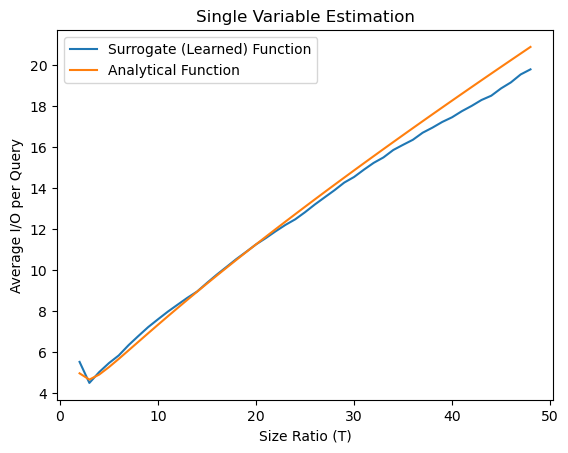

In [76]:
x = df['x']
y_learned = df['learned']
y_analytical = df['analytical']


fig, ax = plt.subplots()
ax.plot(x, y_learned, label='Surrogate (Learned) Function')
ax.plot(x, y_analytical, label='Analytical Function')
ax.set_xlabel('Size Ratio (T)')
ax.set_ylabel('Average I/O per Query')
ax.set_title('Single Variable Estimation')
ax.legend()
workload = config_model['workloads'][idx]
workload

In [12]:
def gen_hist_data(workload):
    df = []
    for h_p in tqdm(np.arange(0, H_UPPER_LIM, 0.5), leave=False):
        for T_p in np.arange(T_LOWER_LIM, T_UPPER_LIM, 1):
            for Q_p in range(T_LOWER_LIM - 1, T_p, 1):
                x = [h_p, T_p, Q_p]
                df.append({
                    'workload': workload,
                    'h': h_p,
                    'T': T_p,
                    'Q': Q_p,
                    'learned': cost_func_learned_eval(x, workload),
                    'analytical': cost_func_objective(x, workload),
                })
    return pd.DataFrame(df)

  0%|          | 0/19 [00:00<?, ?it/s]

{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, 'w': 0.25}

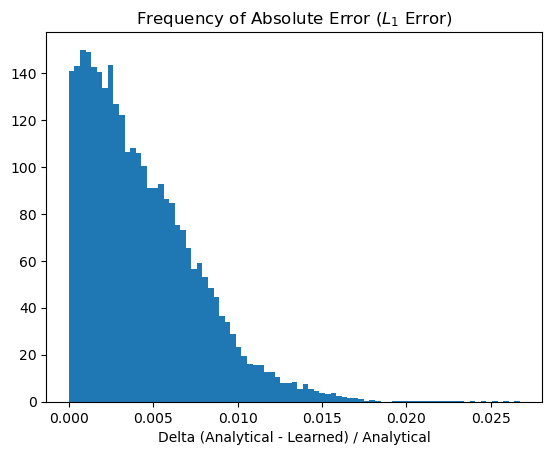

In [77]:
idx = 0
df = gen_hist_data(config_model['workloads'][idx])

df['delta'] = abs((df['analytical'] - df['learned']) / df['analytical'])
n, bins, patches = plt.hist(x=df['delta'], bins='auto', density=True)
plt.xlabel('Delta (Analytical - Learned) / Analytical')
plt.title('Frequency of Absolute Error ($L_1$ Error)')
config_model['workloads'][idx]

In [78]:
df

,workload,h,T,Q,learned,analytical,delta
0,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.0,2,1,5.345865,5.211643,0.025754
1,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.0,3,1,3.752689,3.733320,0.005188
2,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.0,3,2,5.832992,5.852271,0.003294
3,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.0,4,1,3.291880,3.303988,0.003665
4,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.0,4,2,4.831085,4.853151,0.004547
...,...,...,...,...,...,...,...
21427,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",9.0,48,43,25.962715,25.812482,0.005820
21428,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",9.0,48,44,26.546806,26.396304,0.005702
21429,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",9.0,48,45,27.125813,26.980286,0.005394
21430,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",9.0,48,46,27.696644,27.564419,0.004797


In [78]:
df

,workload,h,T,Q,learned,analytical,delta
0,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.0,2,1,5.345865,5.211643,0.025754
1,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.0,3,1,3.752689,3.733320,0.005188
2,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.0,3,2,5.832992,5.852271,0.003294
3,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.0,4,1,3.291880,3.303988,0.003665
4,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.0,4,2,4.831085,4.853151,0.004547
...,...,...,...,...,...,...,...
21427,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",9.0,48,43,25.962715,25.812482,0.005820
21428,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",9.0,48,44,26.546806,26.396304,0.005702
21429,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",9.0,48,45,27.125813,26.980286,0.005394
21430,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",9.0,48,46,27.696644,27.564419,0.004797


In [14]:
dfs = []
for wl in tqdm(config_model['workloads']):
    dfs.append(gen_hist_data(wl))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

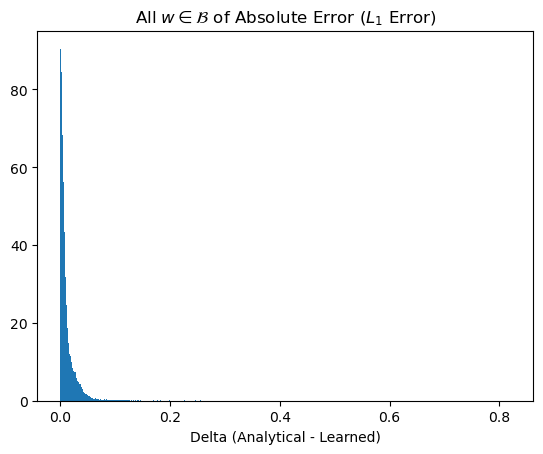

In [15]:
df = pd.concat(dfs)

df['delta'] = abs((df['analytical'] - df['learned']) / df['analytical'])
n, bins, patches = plt.hist(x=df['delta'], bins='auto', density=True)
plt.xlabel('Delta (Analytical - Learned)')
plt.title('All $w \in \mathcal{B}$ of Absolute Error ($L_1$ Error)')
None

In [16]:
df.sort_values(by='delta')

,workload,h,T,Q,learned,analytical,delta
19369,"{'id': 2, 'z0': 0.01, 'z1': 0.97, 'q': 0.01, '...",8.5,21,4,1.157151,1.157151,5.952929e-09
4742,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",2.0,22,21,15.907938,15.907937,3.377446e-08
783,"{'id': 14, 'z0': 0.01, 'z1': 0.33, 'q': 0.33, ...",0.0,41,4,4.964554,4.964554,7.237456e-08
13454,"{'id': 11, 'z0': 0.33, 'z1': 0.33, 'q': 0.33, ...",5.5,47,12,8.532163,8.532163,8.776970e-08
17719,"{'id': 9, 'z0': 0.01, 'z1': 0.49, 'q': 0.01, '...",7.5,41,20,1.876100,1.876099,9.776837e-08
...,...,...,...,...,...,...,...
20325,"{'id': 1, 'z0': 0.97, 'z1': 0.01, 'q': 0.01, '...",9.0,8,1,0.276319,0.159787,7.292949e-01
20307,"{'id': 1, 'z0': 0.97, 'z1': 0.01, 'q': 0.01, '...",9.0,4,1,0.295578,0.167250,7.672806e-01
20319,"{'id': 1, 'z0': 0.97, 'z1': 0.01, 'q': 0.01, '...",9.0,7,1,0.280960,0.158103,7.770667e-01
20314,"{'id': 1, 'z0': 0.97, 'z1': 0.01, 'q': 0.01, '...",9.0,6,1,0.286692,0.157824,8.165358e-01


In [58]:
def generate_configurations():
    df = []
    for wl in tqdm(config_model['workloads']):
        z0, z1, q, w = (wl['z0'], wl['z1'], wl['q'], wl['w'])
        learn = optimize(func=lambda x: cost_func_learned(x, wl), eps=1e-3)
        hand = optimize(func=lambda x: cost_func_objective(x, wl), eps=1e-3)
        df.append({
            'id': wl['id'],
            'wl': wl,
            'learn': learn,
            'hand': hand,
            'delta': cost_func_objective(hand.x, wl) - cost_func_objective(learn.x, wl)
        })
    return pd.DataFrame(df)

df = generate_configurations()

  0%|          | 0/15 [00:00<?, ?it/s]

In [88]:
def sample_workload(dimensions: int=4) -> list:
    # See stackoverflow thread for why the simple solution is not uniform
    # https://stackoverflow.com/questions/8064629/random-numbers-that-add-to-100-matlab
    workload = list(np.random.rand(dimensions - 1)) + [0, 1]
    workload.sort()
    return [b - a for a, b in zip(workload, workload[1:])]

def gen_workload_heat(samples=10):
    df = []
    for _ in tqdm(range(samples)):
        z0, z1, q, w = sample_workload(dimensions=4)
        wl = {'z0': z0, 'z1': z1, 'q': q, 'w': w}
        learn = optimize(func=lambda x: cost_func_learned(x, wl), eps=1e-3, display=False)
        hand = optimize(func=lambda x: cost_func_objective(x, wl), eps=1e-3, display=False)
        cost_learn = cost_func_objective(learn.x, wl)
        cost_hand = cost_func_objective(hand.x, wl)
        df.append({
            'wl': wl,
            'learn': learn,
            'hand': hand,
            'cost_learn': cost_learn,
            'cost_hand': cost_hand,
        })
    return pd.DataFrame(df)

In [89]:
df = gen_workload_heat(500)

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Frequency of Error: Positive is Better')

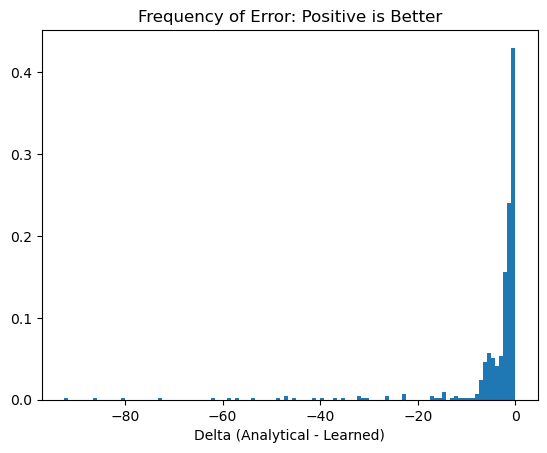

In [90]:
df['delta'] = (df['cost_hand'] - df['cost_learn'])
n, bins, patches = plt.hist(x=df['delta'], bins='auto', density=True)
plt.xlabel('Delta (Analytical - Learned)')
plt.title('Frequency of Error: Positive is Better')

In [91]:
df.sort_values(by='delta')

,wl,learn,hand,cost_learn,cost_hand,delta
23,"{'z0': 0.065159264592063, 'z1': 0.030590208889...","{'x': [3.1533840151004045e-20, 18.000013967731...","{'x': [0.0, 20.242686283525952, 1.000000000000...",95.298786,2.880002,-92.418784
318,"{'z0': 0.06961860605087167, 'z1': 0.0184948045...","{'x': [4.7460617346032216e-20, 30.000010289659...","{'x': [0.29694349127146263, 45.18573169495333,...",88.074502,2.213376,-85.861126
192,"{'z0': 0.10669564206854032, 'z1': 0.2100202183...","{'x': [1.0642044873745353, 11.000166032790219,...","{'x': [1.2803144211194006, 11.698417508546834,...",83.456352,2.928912,-80.527441
197,"{'z0': 0.0020563078645614574, 'z1': 0.10371656...","{'x': [3.24804858744593e-16, 33.00003275021991...","{'x': [0.0, 30.9875556328532, 1.00000000000000...",75.052817,2.455765,-72.597052
496,"{'z0': 0.11701555094633542, 'z1': 0.1489487360...","{'x': [1.022985152469965, 11.996750375560092, ...","{'x': [1.2389168243054336, 12.173275149582466,...",65.245959,3.021224,-62.224734
...,...,...,...,...,...,...
134,"{'z0': 0.8169785194081594, 'z1': 0.07644841977...","{'x': [8.277644889888421, 3.9996913765288755, ...","{'x': [8.154131418678949, 7.428032290330224, 2...",0.682308,0.648029,-0.034279
63,"{'z0': 0.6624210003590694, 'z1': 0.28533896658...","{'x': [8.366104694848557, 4.99377971786652, 3....","{'x': [9.434784352364312, 8.520948103554247, 5...",0.536699,0.513368,-0.023331
73,"{'z0': 0.6065233384440194, 'z1': 0.04290012011...","{'x': [5.484386555503383, 10.242924036560431, ...","{'x': [4.896939416937829, 12.438992877393686, ...",1.559232,1.543780,-0.015451
166,"{'z0': 0.20855294948590586, 'z1': 0.2921772267...","{'x': [2.7322448121766123, 7.000000037092987, ...","{'x': [2.8837505503246965, 7.560601351706164, ...",2.689916,2.682950,-0.006966


In [84]:
df.iloc[320].wl

{'z0': 0.025308808050431453,
 'z1': 0.1805680163959026,
 'q': 0.7675773956762405,
 'w': 0.026545779877425457}

  0%|          | 0/19 [00:00<?, ?it/s]

{'z0': 0.025308808050431453,
 'z1': 0.1805680163959026,
 'q': 0.7675773956762405,
 'w': 0.026545779877425457}

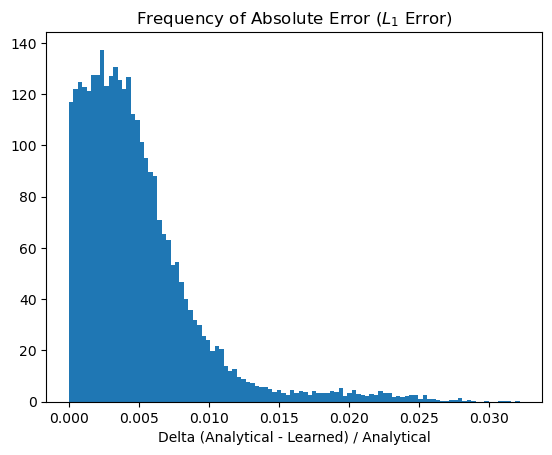

In [85]:
df_tmp = gen_hist_data(df.iloc[320].wl)

df_tmp['delta'] = abs((df_tmp['analytical'] - df_tmp['learned']) / df_tmp['analytical'])
n, bins, patches = plt.hist(x=df_tmp['delta'], bins='auto', density=True)
plt.xlabel('Delta (Analytical - Learned) / Analytical')
plt.title('Frequency of Absolute Error ($L_1$ Error)')
df.iloc[320].wl

In [87]:
df_tmp

,workload,h,T,Q,learned,analytical,delta
0,"{'z0': 0.025308808050431453, 'z1': 0.180568016...",0.0,2,1,8.116503,8.080491,0.004457
1,"{'z0': 0.025308808050431453, 'z1': 0.180568016...",0.0,3,1,5.273952,5.172827,0.019549
2,"{'z0': 0.025308808050431453, 'z1': 0.180568016...",0.0,3,2,10.107157,10.120298,0.001299
3,"{'z0': 0.025308808050431453, 'z1': 0.180568016...",0.0,4,1,4.251655,4.153709,0.023580
4,"{'z0': 0.025308808050431453, 'z1': 0.180568016...",0.0,4,2,7.972219,8.064957,0.011499
...,...,...,...,...,...,...,...
21427,"{'z0': 0.025308808050431453, 'z1': 0.180568016...",9.0,48,43,77.821976,77.112653,0.009199
21428,"{'z0': 0.025308808050431453, 'z1': 0.180568016...",9.0,48,44,79.732193,78.900665,0.010539
21429,"{'z0': 0.025308808050431453, 'z1': 0.180568016...",9.0,48,45,81.575905,80.688694,0.010995
21430,"{'z0': 0.025308808050431453, 'z1': 0.180568016...",9.0,48,46,83.377571,82.476740,0.010922
